<a href="https://colab.research.google.com/github/satvik-phadte/dog-breed-classifier/blob/main/dog_breed_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [ ]:

!kaggle datasets download -d jessicali9530/stanford-dogs-dataset


Dataset URL: https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset
License(s): other


In [ ]:
!unzip -q stanford-dogs-dataset.zip -d /content/stanford_dogs


In [ ]:
import os
import shutil
import random

src_dir = '/content/stanford_dogs/images/Images'
train_dir = '/content/dog_data/train'
val_dir = '/content/dog_data/val'

os.makedirs(train_dir)
os.makedirs(val_dir)

breeds = os.listdir(src_dir)

for breed in breeds:
    breed_src = os.path.join(src_dir, breed)
    images = os.listdir(breed_src)

    random.shuffle(images)

    split_point = int(0.8 * len(images))
    train_images = images[:split_point]
    val_images = images[split_point:]

    os.makedirs(os.path.join(train_dir, breed), exist_ok=True)
    os.makedirs(os.path.join(val_dir, breed), exist_ok=True)

    for img in train_images:
        src = os.path.join(breed_src, img)
        dst = os.path.join(train_dir, breed, img)
        shutil.copy2(src, dst)

    for img in val_images:
        src = os.path.join(breed_src, img)
        dst = os.path.join(val_dir, breed, img)
        shutil.copy2(src, dst)

print("split")



 Dataset split into train and val.


In [ ]:
print("Train folders:", os.listdir(train_dir)[:5])
print(" example ", os.listdir(os.path.join(train_dir, os.listdir(train_dir)[0]))[:3])



Train folders: ['n02091244-Ibizan_hound', 'n02091134-whippet', 'n02108551-Tibetan_mastiff', 'n02091831-Saluki', 'n02097130-giant_schnauzer']
 example  ['n02091244_465.jpg', 'n02091244_2427.jpg', 'n02091244_530.jpg']


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/dog_data/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    '/content/dog_data/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)




Found 19773 images belonging to 121 classes.
Found 7517 images belonging to 121 classes.


In [ ]:
num_classes = 121


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Regularization
    layers.Dense(num_classes, activation='softmax')
])


In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)


checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[early_stopping, checkpoint]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.2827 - loss: 3.1524
Epoch 1: val_accuracy improved from -inf to 0.73210, saving model to best_model.h5


617/617 ━━━━━━━━━━━━━━━━━━━━ 275s 429ms/step - accuracy: 0.2829 - loss: 3.1510 - val_accuracy: 0.7321 - val_loss: 0.9131
Epoch 2/30
  1/617 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.4062 - loss: 1.8149

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.73210
617/617 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.4062 - loss: 1.8149 - val_accuracy: 0.7310 - val_loss: 0.9123
Epoch 3/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.5777 - loss: 1.4826
Epoch 3: val_accuracy improved from 0.73210 to 0.75414, saving model to best_model.h5


617/617 ━━━━━━━━━━━━━━━━━━━━ 322s 468ms/step - accuracy: 0.5777 - loss: 1.4826 - val_accuracy: 0.7541 - val_loss: 0.7835
Epoch 4/30
  1/617 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - accuracy: 0.6875 - loss: 1.1972
Epoch 4: val_accuracy improved from 0.75414 to 0.75601, saving model to best_model.h5


617/617 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.6875 - loss: 1.1972 - val_accuracy: 0.7560 - val_loss: 0.7834
Epoch 5/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.6134 - loss: 1.3167
Epoch 5: val_accuracy improved from 0.75601 to 0.77804, saving model to best_model.h5


617/617 ━━━━━━━━━━━━━━━━━━━━ 257s 416ms/step - accuracy: 0.6134 - loss: 1.3167 - val_accuracy: 0.7780 - val_loss: 0.7251
Epoch 6/30
  1/617 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - accuracy: 0.7500 - loss: 0.7020
Epoch 6: val_accuracy improved from 0.77804 to 0.77831, saving model to best_model.h5


617/617 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.7500 - loss: 0.7020 - val_accuracy: 0.7783 - val_loss: 0.7233
Epoch 7/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.6404 - loss: 1.2436
Epoch 7: val_accuracy improved from 0.77831 to 0.77858, saving model to best_model.h5


617/617 ━━━━━━━━━━━━━━━━━━━━ 323s 446ms/step - accuracy: 0.6404 - loss: 1.2436 - val_accuracy: 0.7786 - val_loss: 0.6874
Epoch 8/30
  1/617 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.7188 - loss: 1.0474
Epoch 8: val_accuracy improved from 0.77858 to 0.78058, saving model to best_model.h5


617/617 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.7188 - loss: 1.0474 - val_accuracy: 0.7806 - val_loss: 0.6863
Epoch 9/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.6564 - loss: 1.1596
Epoch 9: val_accuracy improved from 0.78058 to 0.78272, saving model to best_model.h5


617/617 ━━━━━━━━━━━━━━━━━━━━ 322s 476ms/step - accuracy: 0.6564 - loss: 1.1597 - val_accuracy: 0.7827 - val_loss: 0.6684
Epoch 10/30
  1/617 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.6250 - loss: 1.6677
Epoch 10: val_accuracy improved from 0.78272 to 0.78459, saving model to best_model.h5


617/617 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.6250 - loss: 1.6677 - val_accuracy: 0.7846 - val_loss: 0.6683
Epoch 11/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.6641 - loss: 1.1348
Epoch 11: val_accuracy improved from 0.78459 to 0.79474, saving model to best_model.h5


617/617 ━━━━━━━━━━━━━━━━━━━━ 259s 420ms/step - accuracy: 0.6641 - loss: 1.1348 - val_accuracy: 0.7947 - val_loss: 0.6469
Epoch 12/30
  1/617 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.7500 - loss: 0.9238
Epoch 12: val_accuracy did not improve from 0.79474
617/617 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.7500 - loss: 0.9238 - val_accuracy: 0.7934 - val_loss: 0.6485
Epoch 13/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.6668 - loss: 1.1320
Epoch 13: val_accuracy improved from 0.79474 to 0.79514, saving model to best_model.h5


617/617 ━━━━━━━━━━━━━━━━━━━━ 259s 420ms/step - accuracy: 0.6668 - loss: 1.1320 - val_accuracy: 0.7951 - val_loss: 0.6321
Epoch 14/30
  1/617 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.7812 - loss: 0.6770
Epoch 14: val_accuracy improved from 0.79514 to 0.79607, saving model to best_model.h5


617/617 ━━━━━━━━━━━━━━━━━━━━ 39s 64ms/step - accuracy: 0.7812 - loss: 0.6770 - val_accuracy: 0.7961 - val_loss: 0.6316
Epoch 15/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.6744 - loss: 1.1037
Epoch 15: val_accuracy improved from 0.79607 to 0.80863, saving model to best_model.h5


617/617 ━━━━━━━━━━━━━━━━━━━━ 280s 415ms/step - accuracy: 0.6744 - loss: 1.1037 - val_accuracy: 0.8086 - val_loss: 0.5943
Epoch 16/30
  1/617 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - accuracy: 0.5625 - loss: 1.2837
Epoch 16: val_accuracy did not improve from 0.80863
617/617 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - accuracy: 0.5625 - loss: 1.2837 - val_accuracy: 0.8078 - val_loss: 0.5977
Epoch 17/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.6763 - loss: 1.0838
Epoch 17: val_accuracy improved from 0.80863 to 0.81464, saving model to best_model.h5


617/617 ━━━━━━━━━━━━━━━━━━━━ 320s 449ms/step - accuracy: 0.6763 - loss: 1.0839 - val_accuracy: 0.8146 - val_loss: 0.5829
Epoch 18/30
  1/617 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.5938 - loss: 1.0170
Epoch 18: val_accuracy did not improve from 0.81464
617/617 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.5938 - loss: 1.0170 - val_accuracy: 0.8130 - val_loss: 0.5829
Epoch 19/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.6826 - loss: 1.0614
Epoch 19: val_accuracy did not improve from 0.81464
617/617 ━━━━━━━━━━━━━━━━━━━━ 291s 428ms/step - accuracy: 0.6826 - loss: 1.0614 - val_accuracy: 0.8117 - val_loss: 0.5765
Epoch 20/30
  1/617 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.5938 - loss: 1.3508
Epoch 20: val_accuracy did not improve from 0.81464
617/617 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.5938 - loss: 1.3508 - val_accuracy: 0.8117 - val_loss: 0.5740
Epoch 21/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.6877 - loss: 1.0582
Epoch 21

617/617 ━━━━━━━━━━━━━━━━━━━━ 262s 424ms/step - accuracy: 0.6877 - loss: 1.0582 - val_accuracy: 0.8204 - val_loss: 0.5594
Epoch 22/30
  1/617 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.6562 - loss: 0.9946
Epoch 22: val_accuracy did not improve from 0.82038
617/617 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.6562 - loss: 0.9946 - val_accuracy: 0.8202 - val_loss: 0.5603
Epoch 23/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.6920 - loss: 1.0225
Epoch 23: val_accuracy improved from 0.82038 to 0.82519, saving model to best_model.h5


617/617 ━━━━━━━━━━━━━━━━━━━━ 322s 521ms/step - accuracy: 0.6920 - loss: 1.0226 - val_accuracy: 0.8252 - val_loss: 0.5525
Epoch 24/30
  1/617 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.6250 - loss: 1.0397
Epoch 24: val_accuracy did not improve from 0.82519
617/617 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.6250 - loss: 1.0397 - val_accuracy: 0.8243 - val_loss: 0.5545
Epoch 25/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.6940 - loss: 1.0051
Epoch 25: val_accuracy improved from 0.82519 to 0.82973, saving model to best_model.h5


617/617 ━━━━━━━━━━━━━━━━━━━━ 319s 454ms/step - accuracy: 0.6939 - loss: 1.0052 - val_accuracy: 0.8297 - val_loss: 0.5407
Epoch 26/30
  1/617 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.7812 - loss: 0.6865
Epoch 26: val_accuracy improved from 0.82973 to 0.83066, saving model to best_model.h5


617/617 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.7812 - loss: 0.6865 - val_accuracy: 0.8307 - val_loss: 0.5389
Epoch 27/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.7090 - loss: 0.9731
Epoch 27: val_accuracy improved from 0.83066 to 0.83267, saving model to best_model.h5


617/617 ━━━━━━━━━━━━━━━━━━━━ 322s 523ms/step - accuracy: 0.7090 - loss: 0.9731 - val_accuracy: 0.8327 - val_loss: 0.5271
Epoch 28/30
  1/617 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - accuracy: 0.7188 - loss: 1.0677
Epoch 28: val_accuracy improved from 0.83267 to 0.83320, saving model to best_model.h5


617/617 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.7188 - loss: 1.0677 - val_accuracy: 0.8332 - val_loss: 0.5294
Epoch 29/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.7046 - loss: 0.9647
Epoch 29: val_accuracy did not improve from 0.83320
617/617 ━━━━━━━━━━━━━━━━━━━━ 322s 455ms/step - accuracy: 0.7046 - loss: 0.9648 - val_accuracy: 0.8332 - val_loss: 0.5180
Epoch 30/30
  1/617 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.6875 - loss: 1.1280
Epoch 30: val_accuracy did not improve from 0.83320
617/617 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.6875 - loss: 1.1280 - val_accuracy: 0.8329 - val_loss: 0.5177
Restoring model weights from the end of the best epoch: 30.


In [ ]:
model.evaluate(val_generator)


235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.8345 - loss: 0.5085


[0.5172618627548218, 0.833311140537262]

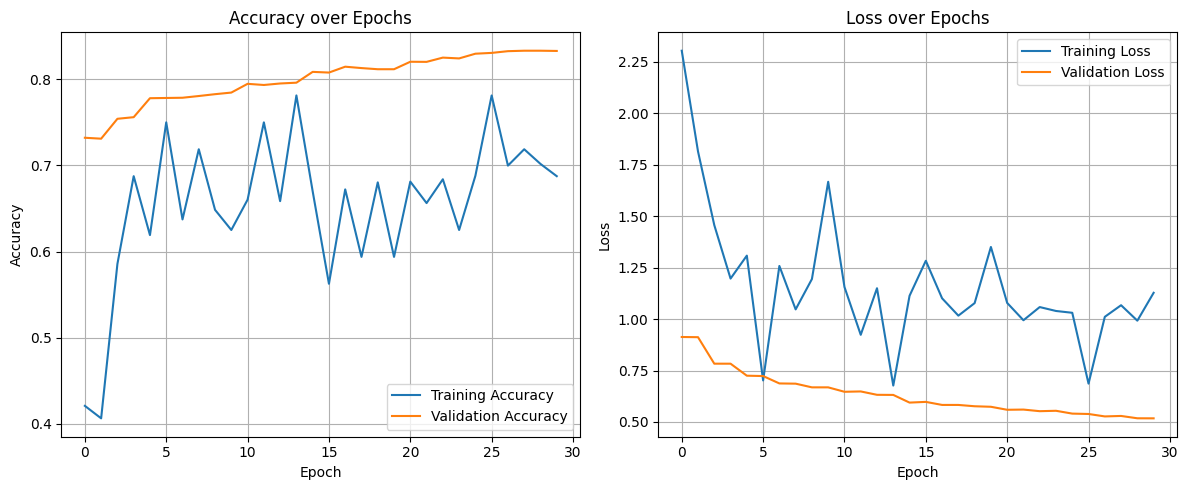

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


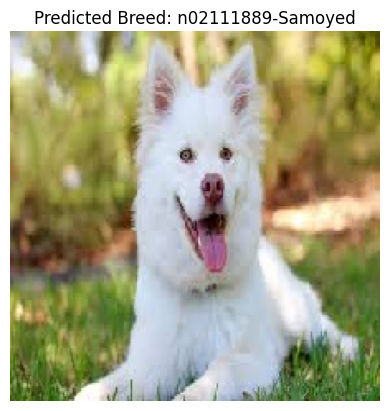

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt


#  preprocessing image
img = image.load_img('/content/dog4.jpg', target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.

#  prediction
pred = model.predict(img_array)
predicted_class = np.argmax(pred)

# class labels
class_labels = list(train_generator.class_indices.keys())
breed = class_labels[predicted_class]

#  result
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted Breed: {breed}')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


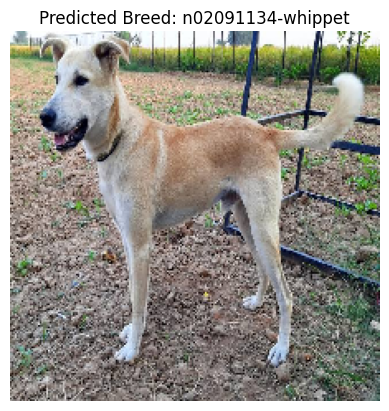

In [ ]:
#  preprocessing the image
img = image.load_img('/content/dog5.jpg', target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.

#  prediction
pred = model.predict(img_array)
predicted_class = np.argmax(pred)

# class labels
class_labels = list(train_generator.class_indices.keys())
breed = class_labels[predicted_class]

#  result
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted Breed: {breed}')
plt.show()

thats a wrong prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


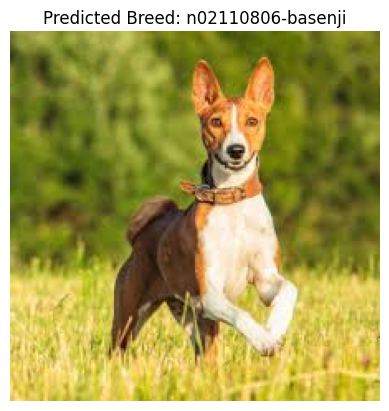

In [ ]:
#  preprocessing
img = image.load_img('/content/dog6.jpg', target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.


pred = model.predict(img_array)
predicted_class = np.argmax(pred)


class_labels = list(train_generator.class_indices.keys())
breed = class_labels[predicted_class]


plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted Breed: {breed}')
plt.show()